#### L'effetto della normalizzazione  
<p>
Ho sperimentato gli effetti della normalizzazione su due tipi di celle: 
    
    1- con andamento regolare: peggioramento marginale dell'errore di previsione cioè(0.2)
    
    2- con andamento irregolare: miglioramento dell'errore di previsoine solo marginale (cioè 0.1) 
</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from time import time
import os
from IPython.utils import traitlets as _traitlets
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import TensorBoard
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import warnings 
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras import metrics

data = pd.read_csv('/Users/alket/desktop/dati/new_data_backfill_forwfill.csv', index_col = 0)

Using TensorFlow backend.
/Users/alket/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  app.launch_new_instance()


In [2]:
# aggrega per numero cella
agg_by_cell = data.groupby(by = data['cell_num'])
print(len(agg_by_cell))

221


In [3]:
series = agg_by_cell.get_group('487-1252')['nr_people']
series_values = agg_by_cell.get_group('487-1252')['nr_people'].values

In [4]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps for the window
n_steps = 96

# split into samples
X, y = split_sequence(series_values, n_steps)

count = 0
# summarize the data
for i in range(len(X)):
    count +=1
    if count > 1: 
        break
    print(X[i], y[i]) 

[39. 39. 36. 36. 35. 35. 34. 32. 32. 31. 31. 29. 29. 26. 25. 24. 23. 23.
 22. 21. 20. 20. 19. 19. 19. 20. 22. 22. 22. 22. 21. 21. 20. 20. 20. 23.
 23. 25. 25. 29. 30. 30. 30. 29. 28. 27. 28. 28. 29. 29. 30. 30. 32. 32.
 33. 33. 33. 33. 32. 33. 35. 37. 37. 38. 39. 40. 42. 42. 46. 48. 48. 49.
 47. 47. 46. 45. 44. 44. 44. 44. 45. 45. 46. 44. 44. 44. 44. 40. 40. 39.
 39. 39. 36. 35. 35. 35.] 36.0


In [5]:
# define scaler
scaler = MinMaxScaler()

# fit scaler on data
scaler.fit(X)

# apply transform
X = scaler.transform(X)
print(X[0:10])

# fit scaler on data
y = y.reshape(-1, 1)
scaler.fit(y)

# apply transform
y = scaler.transform(y)
print(y[0:10])

[[0.31818182 0.31818182 0.27272727 0.27272727 0.25757576 0.25757576
  0.24242424 0.21212121 0.21212121 0.1969697  0.1969697  0.16666667
  0.16666667 0.12121212 0.10606061 0.09090909 0.07575758 0.07575758
  0.06060606 0.04545455 0.03030303 0.03030303 0.01515152 0.01515152
  0.01515152 0.03030303 0.06060606 0.06060606 0.06060606 0.06060606
  0.04545455 0.04545455 0.03030303 0.03030303 0.03030303 0.07575758
  0.07575758 0.10606061 0.10606061 0.16666667 0.18181818 0.18181818
  0.18181818 0.16666667 0.15151515 0.13636364 0.15151515 0.15151515
  0.16666667 0.16666667 0.18181818 0.18181818 0.21212121 0.21212121
  0.22727273 0.22727273 0.22727273 0.22727273 0.21212121 0.22727273
  0.25757576 0.28787879 0.28787879 0.3030303  0.31818182 0.33333333
  0.36363636 0.36363636 0.42424242 0.45454545 0.45454545 0.46969697
  0.43939394 0.43939394 0.42424242 0.40909091 0.39393939 0.39393939
  0.39393939 0.39393939 0.40909091 0.40909091 0.42424242 0.39393939
  0.39393939 0.39393939 0.39393939 0.33333333 0.

In [6]:
train_X, test_X = X[:8000], X[8000:]
train_y, test_y = y[:8000], y[8000:]

In [7]:
# define model
model = Sequential()

model.add(Dense(500, activation='relu', input_dim=n_steps)) 
model.add(Dense(1))

model.compile(loss='mse',optimizer='adam', metrics=[metrics.mae, 'accuracy'])

model.fit(train_X, train_y, epochs=500, verbose=2)

Epoch 1/500
 - 0s - loss: 0.0077 - mean_absolute_error: 0.0526 - accuracy: 0.0010
Epoch 2/500
 - 0s - loss: 0.0012 - mean_absolute_error: 0.0270 - accuracy: 0.0010
Epoch 3/500
 - 0s - loss: 0.0011 - mean_absolute_error: 0.0257 - accuracy: 0.0010
Epoch 4/500
 - 0s - loss: 9.4966e-04 - mean_absolute_error: 0.0241 - accuracy: 0.0010
Epoch 5/500
 - 0s - loss: 9.7434e-04 - mean_absolute_error: 0.0244 - accuracy: 0.0010
Epoch 6/500
 - 0s - loss: 0.0010 - mean_absolute_error: 0.0254 - accuracy: 0.0010
Epoch 7/500
 - 0s - loss: 8.0403e-04 - mean_absolute_error: 0.0219 - accuracy: 0.0010
Epoch 8/500
 - 0s - loss: 9.9325e-04 - mean_absolute_error: 0.0243 - accuracy: 0.0010
Epoch 9/500
 - 0s - loss: 8.2422e-04 - mean_absolute_error: 0.0224 - accuracy: 0.0010
Epoch 10/500
 - 0s - loss: 9.0014e-04 - mean_absolute_error: 0.0234 - accuracy: 0.0010
Epoch 11/500
 - 0s - loss: 8.7101e-04 - mean_absolute_error: 0.0230 - accuracy: 0.0010
Epoch 12/500
 - 0s - loss: 8.2326e-04 - mean_absolute_error: 0.0222 

Epoch 96/500
 - 0s - loss: 5.0671e-04 - mean_absolute_error: 0.0169 - accuracy: 0.0010
Epoch 97/500
 - 0s - loss: 5.2727e-04 - mean_absolute_error: 0.0174 - accuracy: 0.0010
Epoch 98/500
 - 0s - loss: 5.0891e-04 - mean_absolute_error: 0.0170 - accuracy: 0.0010
Epoch 99/500
 - 0s - loss: 5.4666e-04 - mean_absolute_error: 0.0177 - accuracy: 0.0010
Epoch 100/500
 - 0s - loss: 5.1788e-04 - mean_absolute_error: 0.0172 - accuracy: 0.0010
Epoch 101/500
 - 0s - loss: 4.9511e-04 - mean_absolute_error: 0.0168 - accuracy: 0.0010
Epoch 102/500
 - 0s - loss: 5.3975e-04 - mean_absolute_error: 0.0177 - accuracy: 0.0010
Epoch 103/500
 - 0s - loss: 5.3477e-04 - mean_absolute_error: 0.0175 - accuracy: 0.0010
Epoch 104/500
 - 0s - loss: 5.2554e-04 - mean_absolute_error: 0.0173 - accuracy: 0.0010
Epoch 105/500
 - 0s - loss: 4.9775e-04 - mean_absolute_error: 0.0168 - accuracy: 0.0010
Epoch 106/500
 - 0s - loss: 5.0559e-04 - mean_absolute_error: 0.0170 - accuracy: 0.0010
Epoch 107/500
 - 0s - loss: 4.9342e-

 - 0s - loss: 4.9634e-04 - mean_absolute_error: 0.0168 - accuracy: 0.0010
Epoch 190/500
 - 0s - loss: 4.8343e-04 - mean_absolute_error: 0.0166 - accuracy: 0.0010
Epoch 191/500
 - 0s - loss: 4.7420e-04 - mean_absolute_error: 0.0164 - accuracy: 0.0010
Epoch 192/500
 - 0s - loss: 4.7314e-04 - mean_absolute_error: 0.0164 - accuracy: 0.0010
Epoch 193/500
 - 0s - loss: 4.6943e-04 - mean_absolute_error: 0.0163 - accuracy: 0.0010
Epoch 194/500
 - 0s - loss: 4.9760e-04 - mean_absolute_error: 0.0169 - accuracy: 0.0010
Epoch 195/500
 - 0s - loss: 4.6282e-04 - mean_absolute_error: 0.0161 - accuracy: 0.0010
Epoch 196/500
 - 0s - loss: 4.8918e-04 - mean_absolute_error: 0.0167 - accuracy: 0.0010
Epoch 197/500
 - 0s - loss: 4.8208e-04 - mean_absolute_error: 0.0166 - accuracy: 0.0010
Epoch 198/500
 - 0s - loss: 4.7131e-04 - mean_absolute_error: 0.0164 - accuracy: 0.0010
Epoch 199/500
 - 0s - loss: 4.6764e-04 - mean_absolute_error: 0.0163 - accuracy: 0.0010
Epoch 200/500
 - 0s - loss: 4.6200e-04 - mean_

Epoch 283/500
 - 0s - loss: 4.5573e-04 - mean_absolute_error: 0.0161 - accuracy: 0.0010
Epoch 284/500
 - 0s - loss: 4.6808e-04 - mean_absolute_error: 0.0162 - accuracy: 0.0010
Epoch 285/500
 - 0s - loss: 4.7378e-04 - mean_absolute_error: 0.0163 - accuracy: 0.0010
Epoch 286/500
 - 0s - loss: 4.6348e-04 - mean_absolute_error: 0.0162 - accuracy: 0.0010
Epoch 287/500
 - 0s - loss: 4.5812e-04 - mean_absolute_error: 0.0160 - accuracy: 0.0010
Epoch 288/500
 - 0s - loss: 4.6561e-04 - mean_absolute_error: 0.0162 - accuracy: 0.0010
Epoch 289/500
 - 0s - loss: 4.6086e-04 - mean_absolute_error: 0.0161 - accuracy: 0.0010
Epoch 290/500
 - 0s - loss: 4.5738e-04 - mean_absolute_error: 0.0160 - accuracy: 0.0010
Epoch 291/500
 - 0s - loss: 4.6938e-04 - mean_absolute_error: 0.0163 - accuracy: 0.0010
Epoch 292/500
 - 0s - loss: 4.7969e-04 - mean_absolute_error: 0.0164 - accuracy: 0.0010
Epoch 293/500
 - 0s - loss: 4.5488e-04 - mean_absolute_error: 0.0160 - accuracy: 0.0010
Epoch 294/500
 - 0s - loss: 4.60

 - 0s - loss: 4.5196e-04 - mean_absolute_error: 0.0159 - accuracy: 0.0010
Epoch 377/500
 - 0s - loss: 4.6273e-04 - mean_absolute_error: 0.0162 - accuracy: 0.0010
Epoch 378/500
 - 0s - loss: 4.7129e-04 - mean_absolute_error: 0.0163 - accuracy: 0.0010
Epoch 379/500
 - 0s - loss: 4.5491e-04 - mean_absolute_error: 0.0159 - accuracy: 0.0010
Epoch 380/500
 - 0s - loss: 4.6760e-04 - mean_absolute_error: 0.0161 - accuracy: 0.0010
Epoch 381/500
 - 0s - loss: 4.5421e-04 - mean_absolute_error: 0.0160 - accuracy: 0.0010
Epoch 382/500
 - 0s - loss: 4.5757e-04 - mean_absolute_error: 0.0162 - accuracy: 0.0010
Epoch 383/500
 - 0s - loss: 4.7308e-04 - mean_absolute_error: 0.0163 - accuracy: 0.0010
Epoch 384/500
 - 0s - loss: 4.6379e-04 - mean_absolute_error: 0.0162 - accuracy: 0.0010
Epoch 385/500
 - 0s - loss: 4.4597e-04 - mean_absolute_error: 0.0158 - accuracy: 0.0010
Epoch 386/500
 - 0s - loss: 4.6005e-04 - mean_absolute_error: 0.0161 - accuracy: 0.0010
Epoch 387/500
 - 0s - loss: 4.4814e-04 - mean_

Epoch 470/500
 - 0s - loss: 4.6088e-04 - mean_absolute_error: 0.0161 - accuracy: 0.0010
Epoch 471/500
 - 0s - loss: 4.5724e-04 - mean_absolute_error: 0.0160 - accuracy: 0.0010
Epoch 472/500
 - 0s - loss: 4.5393e-04 - mean_absolute_error: 0.0160 - accuracy: 0.0010
Epoch 473/500
 - 0s - loss: 4.4480e-04 - mean_absolute_error: 0.0158 - accuracy: 0.0010
Epoch 474/500
 - 0s - loss: 4.5433e-04 - mean_absolute_error: 0.0160 - accuracy: 0.0010
Epoch 475/500
 - 0s - loss: 4.4137e-04 - mean_absolute_error: 0.0157 - accuracy: 0.0010
Epoch 476/500
 - 0s - loss: 4.6187e-04 - mean_absolute_error: 0.0162 - accuracy: 0.0010
Epoch 477/500
 - 0s - loss: 4.4668e-04 - mean_absolute_error: 0.0157 - accuracy: 0.0010
Epoch 478/500
 - 0s - loss: 4.4431e-04 - mean_absolute_error: 0.0157 - accuracy: 0.0010
Epoch 479/500
 - 0s - loss: 4.3719e-04 - mean_absolute_error: 0.0157 - accuracy: 0.0010
Epoch 480/500
 - 0s - loss: 4.5899e-04 - mean_absolute_error: 0.0160 - accuracy: 0.0010
Epoch 481/500
 - 0s - loss: 4.39

### Calcolo errore di previsone

In [11]:
# compute error
predicted = np.array([])

for i in range(len(test_X)):
    x_input = test_X[i].reshape((1, n_steps))
    yhat = model.predict(x_input, verbose=0)
    predicted = np.append(predicted, yhat[0]) 

expected = test_y
predicted = predicted.reshape(-1, 1)  
 
predicted = scaler.inverse_transform(predicted)
expected = scaler.inverse_transform(test_y)    
   
# abs difference
difference = abs((expected - predicted))

In [12]:
print(predicted[:10])
expected[:10]

[[26.90406016]
 [26.979839  ]
 [26.9167529 ]
 [27.64733639]
 [27.78561026]
 [27.92233613]
 [28.77668032]
 [29.14533654]
 [31.39484364]
 [34.53170925]]


array([[26.],
       [26.],
       [27.],
       [27.],
       [27.],
       [28.],
       [28.],
       [30.],
       [33.],
       [37.]])

Mean Absolute Error =  1.0517963980432947


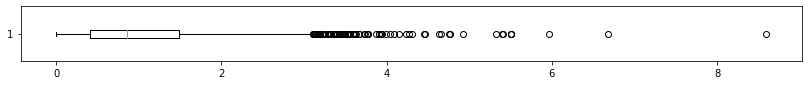

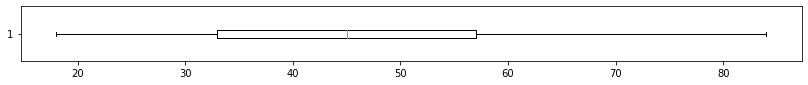

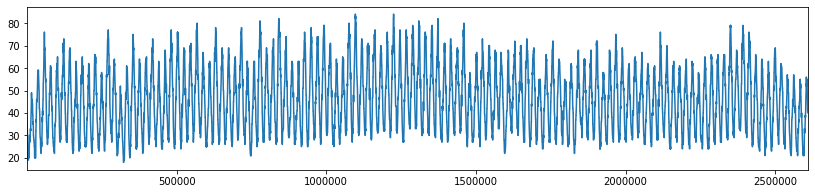

In [13]:
# show boxplot
plt.figure(figsize = (14,1))
plt.boxplot(difference, vert= False);
print('Mean Absolute Error = ', np.mean(difference))

# show boxplot
plt.figure(figsize = (14,1))
plt.boxplot(series, vert= False);
plt.show()

# show boxplot
plt.figure(figsize = (14,3))
series.plot()
plt.show()